# How to build a multi-agent network

!!! info "Prerequisites" 
    This guide assumes familiarity with the following:

    - [How to implement handoffs between agents](../agent-handoffs)
    - [Multi-agent systems](../../concepts/multi_agent)
    - [Command](../../concepts/low_level/#command)
    - [LangGraph Glossary](../../concepts/low_level/)

In this how-to guide we will demonstrate how to implement a [multi-agent network](../../concepts/multi_agent#network) architecture where each agent can communicate with every other agent (many-to-many connections) and can decide which agent to call next. Individual agents will be defined as graph nodes.

To implement communication between the agents, we will be using [handoffs](../agent-handoffs):

```python
def agent(state) -> Command[Literal["agent", "another_agent"]]:
    # the condition for routing/halting can be anything, e.g. LLM tool call / structured output, etc.
    goto = get_next_agent(...)  # 'agent' / 'another_agent'
    return Command(
        # Specify which agent to call next
        goto=goto,
        # Update the graph state
        update={"my_state_key": "my_state_value"}
    )
```

## Setup

First, let's install the required packages

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain-anthropic

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

ANTHROPIC_API_KEY:  ········


<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Using a custom agent implementation

In this example we will build a team of travel assistant agents that can communicate with each other via handoffs.

We will create 2 agents:

* `travel_advisor`: can help with travel destination recommendations. Can ask `hotel_advisor` for help.
* `hotel_advisor`: can help with hotel recommendations. Can ask `travel_advisor` for help.

This is a fully-connected network - every agent can talk to any other agent. 

Each agent will have a corresponding node function that can conditionally return a `Command` object (the handoff). The node function will use an LLM with a system prompt and a tool that lets it signal when it needs to hand off to another agent. If the LLM responds with the tool calls, we will return a `Command(goto=<other_agent>)`.

> **Note**: while we're using tools for the LLM to signal that it needs a handoff, the condition for the handoff can be anything: a specific response text from the LLM, structured output from the LLM, any other custom logic, etc.

Now, let's define our agent nodes and graph!

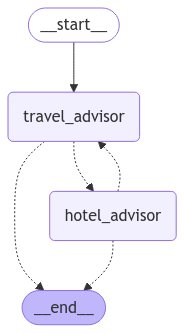

In [43]:
from typing_extensions import Literal

from langchain_core.messages import ToolMessage
from langchain_core.tools import tool
from langchain_anthropic import ChatAnthropic
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.types import Command


model = ChatAnthropic(model="claude-3-5-sonnet-latest")


# Define a helper for each of the agent nodes to call


@tool
def transfer_to_travel_advisor():
    """Ask travel advisor for help."""
    # This tool is not returning anything: we're just using it
    # as a way for LLM to signal that it needs to hand off to another agent
    # (See the paragraph above)
    return


@tool
def transfer_to_hotel_advisor():
    """Ask hotel advisor for help."""
    return


def travel_advisor(
    state: MessagesState,
) -> Command[Literal["hotel_advisor", "__end__"]]:
    system_prompt = (
        "You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc). "
        "If you need hotel recommendations, ask 'hotel_advisor' for help."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = model.bind_tools([transfer_to_hotel_advisor]).invoke(messages)
    # If there are tool calls, the LLM needs to hand off to another agent
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        # NOTE: it's important to insert a tool message here because LLM providers are expecting
        # all AI messages to be followed by a corresponding tool result message
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="hotel_advisor", update={"messages": [ai_msg, tool_msg]})

    # If the expert has an answer, return it directly to the user
    return {"messages": [ai_msg]}


def hotel_advisor(
    state: MessagesState,
) -> Command[Literal["travel_advisor", "__end__"]]:
    system_prompt = (
        "You are a hotel expert that can provide hotel recommendations for a given destination. "
        "If you need help picking travel destinations, ask 'travel_advisor' for help."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = model.bind_tools([transfer_to_travel_advisor]).invoke(messages)
    # If there are tool calls, the LLM needs to hand off to another agent
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        # NOTE: it's important to insert a tool message here because LLM providers are expecting
        # all AI messages to be followed by a corresponding tool result message
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="travel_advisor", update={"messages": [ai_msg, tool_msg]})

    # If the expert has an answer, return it directly to the user
    return {"messages": [ai_msg]}


builder = StateGraph(MessagesState)
builder.add_node("travel_advisor", travel_advisor)
builder.add_node("hotel_advisor", hotel_advisor)
# we'll always start with a general travel advisor
builder.add_edge(START, "travel_advisor")

graph = builder.compile()

from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

First, let's invoke it with a generic input:

In [28]:
from langchain_core.messages import convert_to_messages


def pretty_print_messages(update):
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")

    for node_name, node_update in update.items():
        print(f"Update from node {node_name}:")
        print("\n")

        for m in convert_to_messages(node_update["messages"]):
            m.pretty_print()
        print("\n")

In [29]:
for chunk in graph.stream(
    {"messages": [("user", "i wanna go somewhere warm in the caribbean")]}
):
    pretty_print_messages(chunk)

Update from node travel_advisor:


================================== Ai Message ==================================

I'd be happy to help you plan a Caribbean vacation! The Caribbean is perfect for warm weather getaways. Let me suggest some fantastic destinations:

1. Dominican Republic
- Known for beautiful beaches, all-inclusive resorts, and tropical climate
- Popular areas include Punta Cana and Puerto Plata
- Great mix of beaches, culture, and activities

2. Jamaica
- Famous for its laid-back atmosphere and beautiful beaches
- Popular spots include Montego Bay, Negril, and Ocho Rios
- Known for reggae music, delicious cuisine, and water sports

3. Bahamas
- Crystal clear waters and stunning beaches
- Perfect for island hopping
- Great for water activities and swimming with pigs at Pig Beach

4. Turks and Caicos
- Pristine beaches and luxury resorts
- Excellent for snorkeling and diving
- More peaceful and less crowded than some other Caribbean destinations

5. Aruba
- Known for con

You can see that in this case only the first agent (`travel_advisor`) ran. Let's now ask for more recommendations:

In [30]:
for chunk in graph.stream(
    {
        "messages": [
            (
                "user",
                "i wanna go somewhere warm in the caribbean. pick one destination and give me hotel recommendations",
            )
        ]
    }
):
    pretty_print_messages(chunk)

Update from node travel_advisor:


================================== Ai Message ==================================

[{'text': "I'll help you with a Caribbean destination recommendation! Given the vast number of beautiful Caribbean islands, I'll recommend one popular destination: the Dominican Republic, specifically Punta Cana. It offers pristine beaches, warm weather year-round, crystal-clear waters, and excellent resorts.\n\nLet me get some hotel recommendations for Punta Cana by consulting our hotel advisor.", 'type': 'text'}, {'id': 'toolu_01B9djUstpDKHVSy3o3rfzsG', 'input': {}, 'name': 'transfer_to_hotel_advisor', 'type': 'tool_use'}]
Tool Calls:
  transfer_to_hotel_advisor (toolu_01B9djUstpDKHVSy3o3rfzsG)
 Call ID: toolu_01B9djUstpDKHVSy3o3rfzsG
  Args:
================================= Tool Message =================================

Successfully transferred


Update from node hotel_advisor:


================================== Ai Message ==================================

For P

Voila - `travel_advisor` picks a destination and then makes a decision to call `hotel_advisor` for more info!

## Using with a prebuilt ReAct agent

Let's now see how we can implement the same team of travel agents, but give each of the agents some tools to call. We'll be using prebuilt [`create_react_agent`][langgraph.prebuilt.chat_agent_executor.create_react_agent] to implement the agents. First, let's create some of the tools that the agents will be using:

In [31]:
import random
from typing_extensions import Literal


@tool
def get_travel_recommendations():
    """Get recommendation for travel destinations"""
    return random.choice(["aruba", "turks and caicos"])


@tool
def get_hotel_recommendations(location: Literal["aruba", "turks and caicos"]):
    """Get hotel recommendations for a given destination."""
    return {
        "aruba": [
            "The Ritz-Carlton, Aruba (Palm Beach)"
            "Bucuti & Tara Beach Resort (Eagle Beach)"
        ],
        "turks and caicos": ["Grace Bay Club", "COMO Parrot Cay"],
    }[location]

Let's also write a helper to create a handoff tool. See [this how-to guide](../agent-handoffs#implementing-handoffs-using-tools) for a more in-depth walkthrough of how to make a handoff tool.

In [32]:
from typing import Annotated

from langchain_core.tools import tool
from langchain_core.tools.base import InjectedToolCallId
from langgraph.prebuilt import InjectedState


def make_handoff_tool(*, agent_name: str):
    """Create a tool that can return handoff via a Command"""
    tool_name = f"transfer_to_{agent_name}"

    @tool(tool_name)
    def handoff_to_agent(
        state: Annotated[dict, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ):
        """Ask another agent for help."""
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": tool_name,
            "tool_call_id": tool_call_id,
        }
        return Command(
            # navigate to another agent node in the PARENT graph
            goto=agent_name,
            graph=Command.PARENT,
            # This is the state update that the agent `agent_name` will see when it is invoked.
            # We're passing agent's FULL internal message history AND adding a tool message to make sure
            # the resulting chat history is valid.
            update={"messages": state["messages"] + [tool_message]},
        )

    return handoff_to_agent

Now let's define our agent nodes and combine them into a graph:

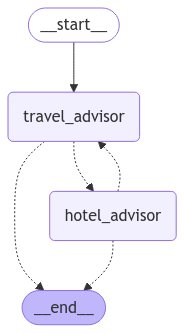

In [42]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command


model = ChatAnthropic(model="claude-3-5-sonnet-latest")

# Define travel advisor ReAct agent
travel_advisor_tools = [
    get_travel_recommendations,
    make_handoff_tool(agent_name="hotel_advisor"),
]
travel_advisor = create_react_agent(
    model,
    travel_advisor_tools,
    prompt=(
        "You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc). "
        "If you need hotel recommendations, ask 'hotel_advisor' for help. "
        "You MUST include human-readable response before transferring to another agent."
    ),
)


def call_travel_advisor(
    state: MessagesState,
) -> Command[Literal["hotel_advisor", "__end__"]]:
    # You can also add additional logic like changing the input to the agent / output from the agent, etc.
    # NOTE: we're invoking the ReAct agent with the full history of messages in the state
    return travel_advisor.invoke(state)


# Define hotel advisor ReAct agent
hotel_advisor_tools = [
    get_hotel_recommendations,
    make_handoff_tool(agent_name="travel_advisor"),
]
hotel_advisor = create_react_agent(
    model,
    hotel_advisor_tools,
    prompt=(
        "You are a hotel expert that can provide hotel recommendations for a given destination. "
        "If you need help picking travel destinations, ask 'travel_advisor' for help."
        "You MUST include human-readable response before transferring to another agent."
    ),
)


def call_hotel_advisor(
    state: MessagesState,
) -> Command[Literal["travel_advisor", "__end__"]]:
    return hotel_advisor.invoke(state)


builder = StateGraph(MessagesState)
builder.add_node("travel_advisor", call_travel_advisor)
builder.add_node("hotel_advisor", call_hotel_advisor)
# we'll always start with a general travel advisor
builder.add_edge(START, "travel_advisor")

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

Let's test it out using the same input as our original multi-agent system:

In [40]:
for chunk in graph.stream(
    {
        "messages": [
            (
                "user",
                "i wanna go somewhere warm in the caribbean. pick one destination and give me hotel recommendations",
            )
        ]
    },
    subgraphs=True,
):
    pretty_print_messages(chunk)

Update from subgraph travel_advisor:


Update from node agent:


================================== Ai Message ==================================

[{'text': "I'll help you find a warm Caribbean destination and get some hotel recommendations for you.\n\nLet me first get some travel recommendations for Caribbean destinations.", 'type': 'text'}, {'id': 'toolu_01GGDP6XSoJZFCYVA9Emhg89', 'input': {}, 'name': 'get_travel_recommendations', 'type': 'tool_use'}]
Tool Calls:
  get_travel_recommendations (toolu_01GGDP6XSoJZFCYVA9Emhg89)
 Call ID: toolu_01GGDP6XSoJZFCYVA9Emhg89
  Args:


Update from subgraph travel_advisor:


Update from node tools:


================================= Tool Message =================================
Name: get_travel_recommendations

turks and caicos


Update from subgraph travel_advisor:


Update from node agent:


================================== Ai Message ==================================

[{'text': 'Based on the recommendations, I suggest Turks and Caicos! Th